In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

In [6]:
### common parameters
agnetsCount = 1000
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.005), np.arange(0.1, 1, 0.05)
])
alphas = np.concatenate([
    np.arange(0.1, 1, 0.05), np.arange(1, 2.1, 0.5)
])
class1, class2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
speedV = 3
dt = 0.01

targetPath = "lastState.h5"  # lastStateAfter  # lastStateRing  # lastState
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalDotTheta = pd.read_hdf(targetPath, key="pointTheta")
modelNums = totalPositionX.shape[0] // agnetsCount
totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalDotTheta = totalDotTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionXs, phaseThetas, dotThetas = dict(), dict(), dict()

np.random.seed(10)
omegaTheta = np.concatenate([
    np.random.uniform(1, 3, size=500),
    np.random.uniform(-3, -1, size=500)
])

for l, a in product(rangeLambdas, alphas):
    
    positionXs[f"{l:.3f}_{a:.2f}"] = totalPositionX[idx]
    phaseThetas[f"{l:.3f}_{a:.2f}"] = totalPhaseTheta[idx]
    dotThetas[f"{l:.3f}_{a:.2f}"] = totalDotTheta[idx]

    idx += 1

In [7]:
# Plot Big Graph
fig = plt.figure(figsize=(len(alphas) * 5, len(rangeLambdas) * 5))

idx = 1

for l, a in tqdm(product(rangeLambdas, alphas), total=len(rangeLambdas) * len(alphas)):
    
    key = f"{l:.3f}_{a:.2f}"

    singlePositionX = positionXs[key]
    singlePhaseTheta = phaseThetas[key]
    singlePointTheta = dotThetas[key]

    ax = plt.subplot(len(rangeLambdas), len(alphas), idx)
    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='red', alpha=0.8
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='blue', alpha=0.8
    )

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)    
    ax.set_title(key)

    idx += 1

plt.tight_layout()
plt.savefig("bigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

  0%|          | 0/756 [00:00<?, ?it/s]

In [36]:
maps1 = pd.DataFrame(index=rangeLambdas, columns=alphas, dtype=np.float64)
for l, d0 in product(rangeLambdas, alphas):

    lastPositionX = positionXs[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseThetas[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = dotThetas[f"{l:.3f}_{d0:.2f}"]
    state = (lastPositionX, lastPhaseTheta, lastPointTheta)

    phaseAggOp = StateAnalysis().calc_order_parameter_R(state)
    maps1.loc[l, d0] = phaseAggOp
maps1.index = np.round(maps1.index, 4)
maps1.columns = np.round(maps1.columns, 4)

maps2 = pd.DataFrame(index=rangeLambdas, columns=alphas, dtype=np.float64)
for l, d0 in product(rangeLambdas, alphas):
    lastPositionX = positionXs[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseThetas[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = dotThetas[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV, dt)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 0.3, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    sumR = 0
    for classOcsis in classes:
        if len(classOcsis) <= 5:
            continue
        sumR += StateAnalysis().calc_order_parameter_R((None, lastPhaseTheta[classOcsis], None))
        counts += 1
    
    maps2.loc[l, d0] = sumR / counts
maps2.index = np.round(maps2.index, 4)
maps2.columns = np.round(maps2.columns, 4)

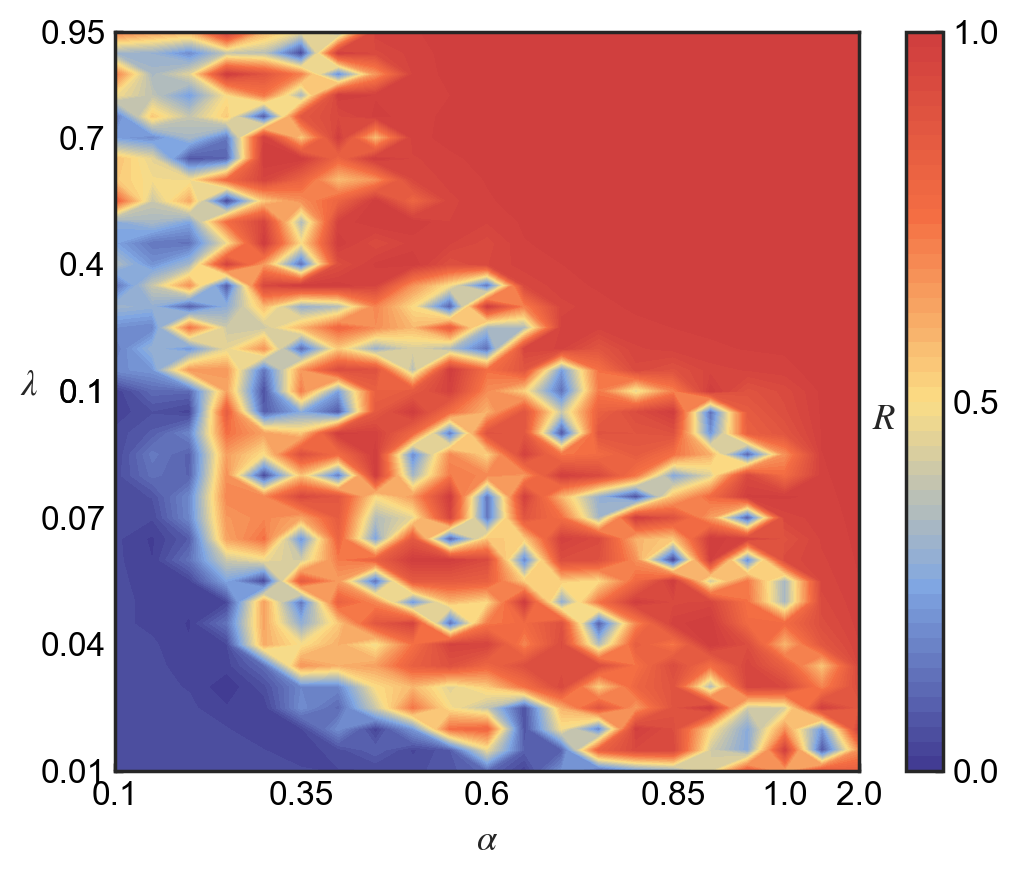

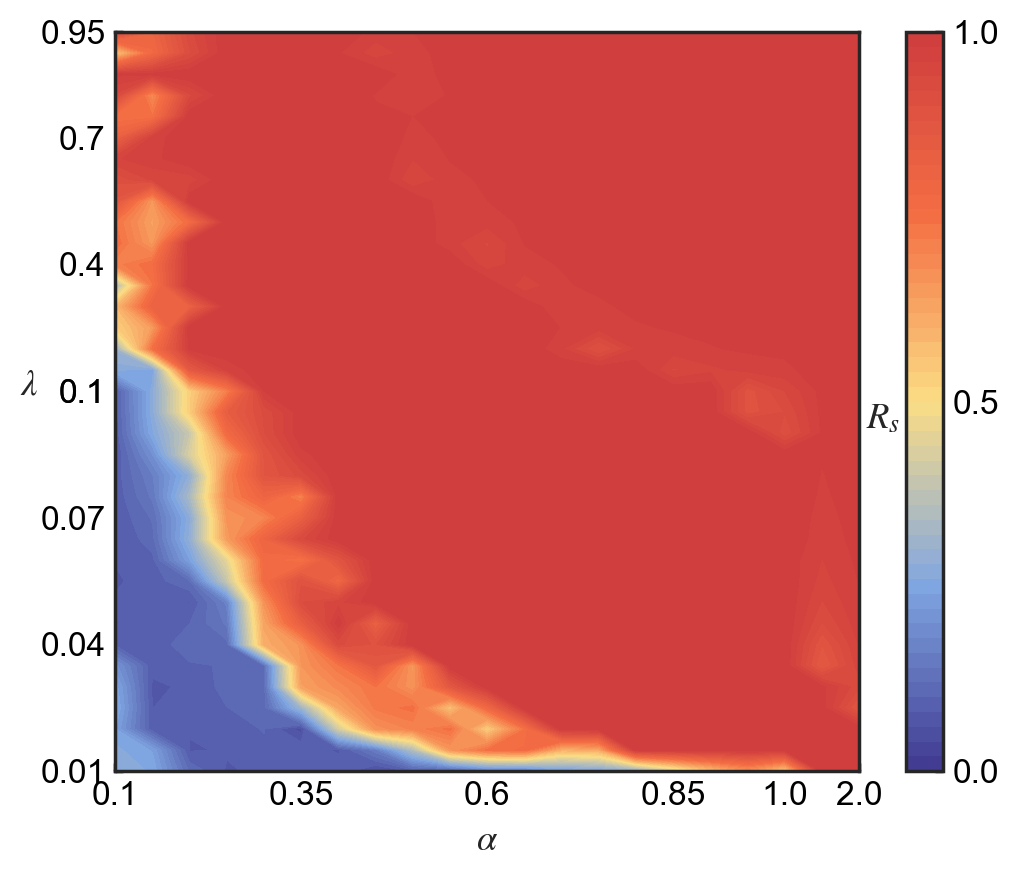

In [48]:
sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

xIdxs = np.arange(len(alphas), step=5)
xIdxs = np.insert(xIdxs, -1, 18)
yIdxs = np.concatenate([np.arange(19, step=6), 18 + np.arange(18, step=6)[1:], [35]])
idx = np.where(rangeLambdas == 0.1)[0][0]
yIdxs = np.insert(yIdxs, 4, idx)

plt.figure(figsize=(6, 4.8))
plt.contourf(
    maps1, levels=50, vmin=0, vmax=1,
    cmap=cmap,
)
cbar = plt.colorbar(ticks=[0, 0.5, 1])
cbar.ax.tick_params(direction='in', length=3)
cbar.set_label(r"$R$", rotation=0, loc="center")
cbar.ax.yaxis.set_label_coords(-0.6, 0.5)
plt.tick_params(direction='in', length=3)
plt.xticks(xIdxs, np.round(alphas[xIdxs], 2))
plt.yticks(yIdxs, np.round(rangeLambdas[yIdxs], 2))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\lambda$", rotation=0)
plt.show()

plt.figure(figsize=(6, 4.8))
stdMap2 = maps2.copy()
stdMap2.iloc[0, 0] = 0
cf2 = plt.contourf(
    stdMap2, levels=50, vmin=0, vmax=1,
    cmap=cmap,
)
plt.contourf(
    maps2, levels=50, vmin=0, vmax=1,
    cmap=cmap,
)
cbar = plt.colorbar(cf2, ticks=[0, 0.5, 1])
cbar.ax.tick_params(direction='in', length=3)
cbar.set_label(r"$R_s$", rotation=0, loc="center")
cbar.ax.yaxis.set_label_coords(-0.6, 0.5)
plt.tick_params(direction='in', length=3)
plt.xticks(xIdxs, np.round(alphas[xIdxs], 2))
plt.yticks(yIdxs, np.round(rangeLambdas[yIdxs], 2))
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\lambda$", rotation=0)
plt.show()